In [ ]:

!pip install transformers[sentencepiece]
!pip install datasets
!pip install evaluate
!pip install seqeval
!pip install transformers[torch]

In [3]:
import torch
import numpy as np
from transformers import AutoModelForTokenClassification
import transformers
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer
import evaluate
from huggingface_hub import notebook_login
from tqdm.auto import tqdm

from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from huggingface_hub import Repository, get_full_repo_name

In [4]:
notebook_login()

In [5]:
dataset = load_dataset("go_emotions")

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [6]:
print(dataset)
dataset['train']['labels']


LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

id2label = {idx:label for idx, label in enumerate(LABELS)}
label2id = {label:idx for idx, label in enumerate(LABELS)}

print(id2label)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


In [7]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

(…)bert-base-cased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

(…)o/bert-base-cased/resolve/main/vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

(…)t-base-cased/resolve/main/tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [8]:
def preprocess_function(examples):
  text = examples["text"]
  encoding = tokenizer(text, truncation=True)
  label_mat = np.zeros((len(text), len(LABELS))).astype(np.float32)
  for i in range(len(text)):
    for l in examples['labels'][i]:
      label_mat[i][l] = 1.0
  label_mat = [[float(i) for i in row]  for row in label_mat]
  encoding['labels'] = label_mat

  return encoding

tokenized_dataset = dataset.map(preprocess_function, batched=True)
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Cast type to float
from datasets import Value, Sequence, Features, ClassLabel

new_features = tokenized_dataset['train'].features.copy()
new_features["labels"] = Sequence(Value("float32"))
tokenized_dataset['train'] = tokenized_dataset['train'].cast(new_features)

new_features = tokenized_dataset['validation'].features.copy()
new_features["labels"] = Sequence(Value("float32"))
tokenized_dataset['validation'] = tokenized_dataset['validation'].cast(new_features)

new_features = tokenized_dataset['test'].features.copy()
new_features["labels"] = Sequence(Value("float32"))
tokenized_dataset['test'] = tokenized_dataset['test'].cast(new_features)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/43410 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5426 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [94]:
import evaluate
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score



# Adapted from https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels):
    threshold = 0.1
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    precision_macro_average = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro_average = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'precision': precision_macro_average,
               'recall': recall_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [78]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", problem_type="multi_label_classification",
    num_labels=28, id2label=id2label, label2id=label2id
)
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
    push_to_hub=False,
    metric_for_best_model="f1",
    warmup_ratio = 0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

In [83]:
trainer.save_model('/content/drive/MyDrive/saved3')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/saved3')
model.to('cuda:0')

In [89]:
# print(dataset['test']['text'])
pred = []


for i in range(0, len(dataset['test']['text']), 8):
  test_dataset = tokenizer(dataset['test']['text'][i:(i+8)], return_tensors="pt", truncation=True, padding=True, max_length=30)

  test_dataset['input_ids'] = test_dataset['input_ids'].to('cuda:0')
  test_dataset['token_type_ids'] = test_dataset['token_type_ids'].to('cuda:0')
  test_dataset['attention_mask'] = test_dataset['attention_mask'].to('cuda:0')

  output = model(**test_dataset).logits
  pred.extend(output.cpu().detach().numpy())

pred = np.array(pred)


In [95]:
true = tokenized_dataset['test']['labels']
multi_label_metrics(pred, true)




{'f1': 0.47383898074073205,
 'precision': 0.40032572404303357,
 'recall': 0.5952037463333787,
 'roc_auc': 0.7777564149314122,
 'accuracy': 0.31748664086972544}

In [100]:
from sklearn.metrics import precision_score, recall_score

def multi_label_by_class(predictions, labels):
    threshold = 0.3
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(len(y_pred[0])):
      precision_list.append(precision_score(np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
      recall_list.append(recall_score(np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
      f1_list.append(f1_score(y_true=np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
    return precision_list, recall_list, f1_list

precision_list, recall_list, f1_list = multi_label_by_class(pred, true)
f1_list

[0.6575342465753424,
 0.7992895204262879,
 0.4619289340101523,
 0.3727598566308244,
 0.3508771929824561,
 0.39999999999999997,
 0.34515366430260047,
 0.5050847457627119,
 0.4171779141104294,
 0.30903790087463556,
 0.3503184713375796,
 0.42687747035573126,
 0.46153846153846156,
 0.42990654205607476,
 0.6549707602339182,
 0.8866855524079319,
 0.6,
 0.5747800586510264,
 0.7859922178988327,
 0.31111111111111117,
 0.5483028720626633,
 0.38461538461538464,
 0.2567567567567568,
 0.39999999999999997,
 0.6412213740458016,
 0.5484949832775919,
 0.5314685314685316,
 0.6396420110555409]

In [140]:
header = ['Text', 'True_label', 'True_label_id', 'Pred_label', 'Pred_label_id'] + LABELS
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(pred)).cpu().detach().numpy()
text = dataset['test']['text']
true_label_id = [str(label_list) for label_list in dataset['test']['labels']]
true_label = [str([id2label[l] for l in label_list ]) for label_list in dataset['test']['labels']]
pred_label_id = [np.nonzero(prob >= 0.5)[0].tolist() for prob in probs]
pred_label = [str([id2label[l] for l in label_list ]) for label_list in pred_label_id]
pred_label_id = [str(label_list) for label_list in pred_label_id]
print(np.array(text).shape)

print(probs[0])

results = np.hstack([np.array(text).reshape(-1,1), np.array(true_label).reshape(-1,1), np.array(true_label_id).reshape(-1,1), np.array(pred_label).reshape(-1,1), np.array(pred_label_id).reshape(-1,1), probs])
results = np.vstack([[header], results])

# np.savetxt('GoEmotions_prediction_results_updated.tsv', results, delimiter = '\t', fmt = '%s')

(5427,)
[1.56114344e-03 8.17581778e-04 1.30296010e-03 9.87239648e-04
 4.70537692e-03 1.35874795e-02 3.80286085e-03 2.64330534e-03
 3.97998188e-03 7.92066474e-03 2.08307081e-03 1.36322214e-03
 1.48572866e-03 9.75492643e-04 4.40244155e-04 9.84304701e-04
 6.28055073e-03 1.08775578e-03 9.76798952e-01 7.98426685e-04
 1.79443334e-03 4.74037981e-04 1.31928967e-02 5.37477143e-04
 2.04998434e-01 1.78954571e-01 2.07664282e-03 2.18927860e-02]


In [102]:
for i in range(len(true_label[:5000])):
  print(text[i], true_label[i], pred_label[i])

I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett! ['sadness'] ['love']
It's wonderful because it's awful. At not with. ['admiration'] ['admiration', 'disgust']
Kings fan here, good luck to you guys! Will be an interesting game to watch!  ['excitement'] ['excitement', 'optimism']
I didn't know that, thank you for teaching me something today! ['gratitude'] ['gratitude']
They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife. ['neutral'] ['neutral']
Thank you for asking questions and recognizing that there may be things that you don’t know or understand about police tactics. Seriously. Thank you. ['gratitude'] ['gratitude']
You’re welcome ['gratitude'] ['gratitude']
100%! Congrats on your job too! ['gratitude'] ['admiration', 'gratitude']
I’m sorry to hear that friend :(. It’s for the best most likely if she didn’t accept you for who you are ['remorse'] ['remorse']
Girlfriend weak as well, that j

In [141]:
conf_mat = np.zeros((28,28))
true_label_id = [eval(l)  for l in true_label_id]
pred_label_id = [eval(l)  for l in pred_label_id]


for i in range(len(true_label_id)):
  for tl in true_label_id[i]:  # List of true labels
    for pl in pred_label_id[i]: # List of predicted labels
      conf_mat[tl, pl] += 1

# print(conf_mat)

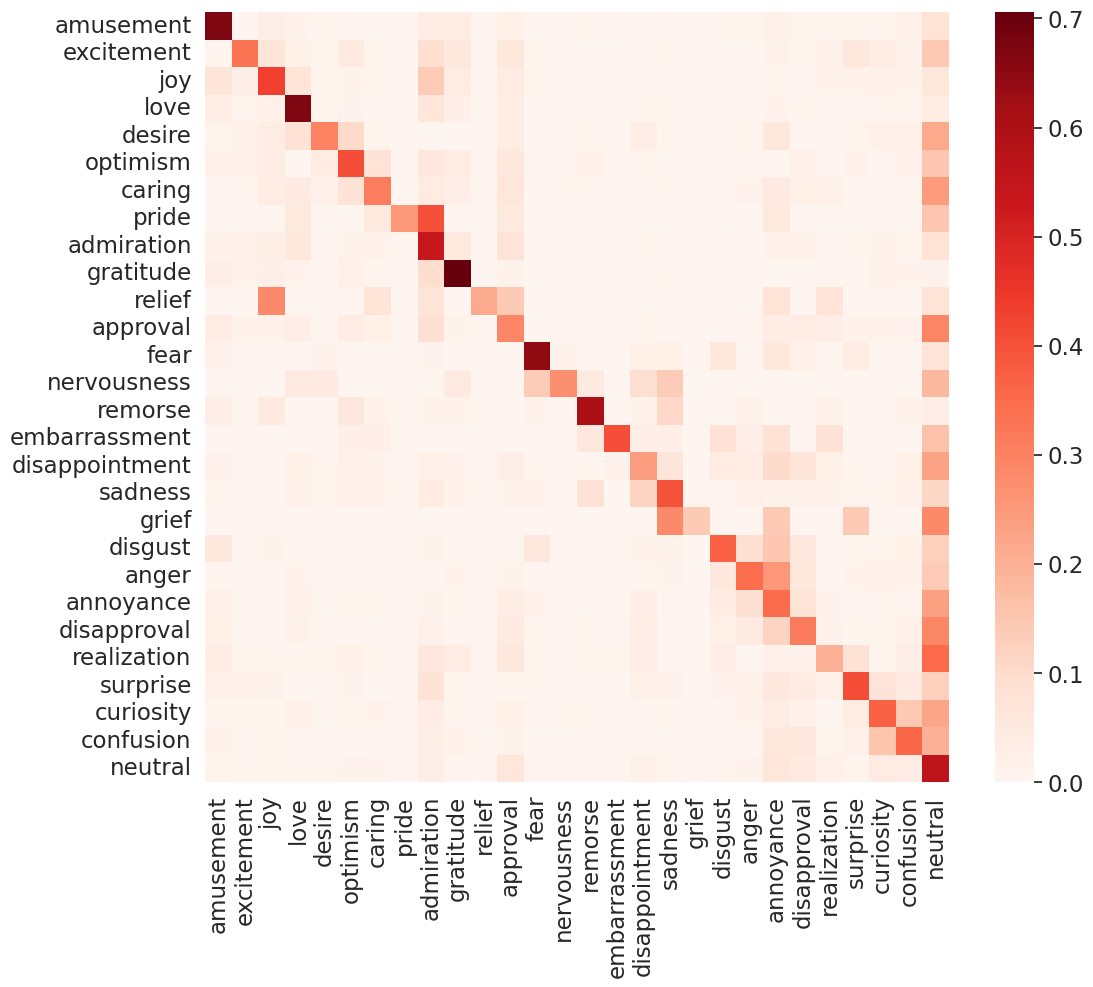

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

group = {
"positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}

order = group["positive"] + group["negative"] + group["ambiguous"] + ['neutral']
ind = [label2id[i]  for i in order]

plt.figure(figsize = (12,10))
sns.set(font_scale=1.5)

conf_mat_plot = np.array(conf_mat / np.sum(conf_mat, axis = 1).reshape(-1,1))
conf_mat_plot = conf_mat_plot[ind][:,ind]
sns.heatmap(conf_mat_plot, cmap = 'Reds', xticklabels = np.array(LABELS)[ind], yticklabels = np.array(LABELS)[ind])

plt.savefig('confusion_matrix.pdf')


<ipython-input-190-82b5b67df820>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_labels = np.array(dataset['test']['labels'] + dataset['train']['labels'] + dataset['validation']['labels'])


63812
[16 21 23 19 12 24 14  8 11 13 26  5 22  9 25  6 17  2 20 18 10  7  1  3
 15  4  0 27]
[   96   142   182   208   375   669   764   801  1013  1052  1330  1375
  1382  1583  1625  1673  1785  1960  1976  2576  2581  2723  2895  3093
  3372  3687  5122 17772]


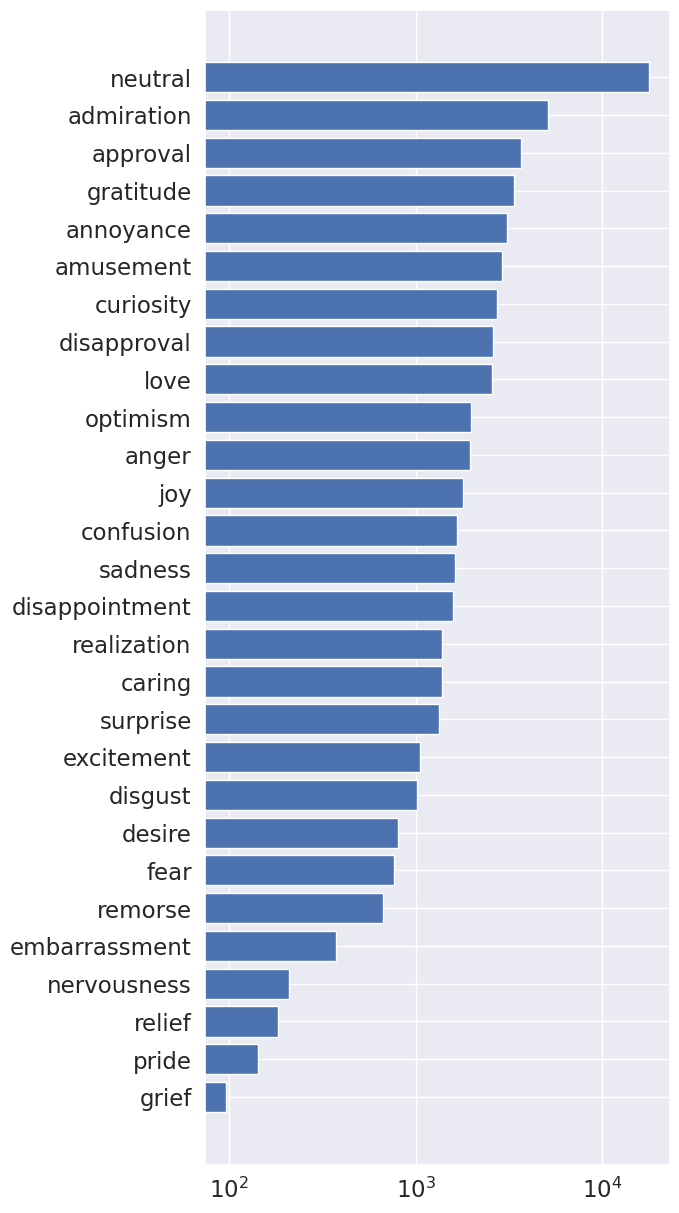

In [190]:
all_labels = np.array(dataset['test']['labels'] + dataset['train']['labels'] + dataset['validation']['labels'])
all_labels = np.concatenate(all_labels)
print(len(all_labels))
labels_count = [np.sum(np.where(all_labels == l, 1, 0)) for l in range(0,28)]
ind = np.argsort(labels_count)
print(ind)
plt.figure(figsize = (6,15))
print(np.array(labels_count)[ind])
plt.barh(np.arange(28), np.array(labels_count)[ind], tick_label = np.array(LABELS)[ind], orientation = 'horizontal', log = True)
plt.savefig('label_distribution.pdf')
